# Time series tests
In this notebook we performed tests on the synthetic generation of time series. It is **not a user guide**, it is meant to give details into what tests we performed and how we did them.

In [2]:
# Import libraries
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm

from sdv.datasets.local import load_csvs

# Get the current file's directory
current_dir = os.path.dirname(os.path.abspath(""))

# Construct the path to the module
module_path = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(module_path)

# Import TimeSeriesGeneration
from src.TimeSeriesGeneration.ts_generator import *
from src.TimeSeriesGeneration.ts_similarity import *
from src.TimeSeriesGeneration.data_processing import *

DATA_PATH = os.path.join(module_path, "data")

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
sns.set_style("whitegrid")
color_plots = ["#003f5c",
#"#58508d",
"#bc5090",
"#ff6361",
"#ffa600"]

## Train model on whole dataset

In [4]:
# Load dataframe
datasets = load_csvs(folder_name=DATA_PATH)
df = datasets["energy_dataset"]
preprocess = DataProcessor(
    df=df
)

In [4]:
# Preprocess data and get metadata
data_processor = DataProcessor(df, obs_limit=1000, interpolate=True, drop_na_cols = True)
# the name of the time column is time in this df and all columns can be used as identifiers in long format
df_real = data_processor.convert_to_long_format(time_columns='time', verbose=False)
metadata = data_processor.get_metadata_long_df(identifier='variable', time_column='time', datetime_format='%Y-%m-%d %H:%M:%S')

In [11]:
ts_gen = TSGenerator(
    df=df_real,
    metadata=metadata,
    verbose=True
)

In [14]:
ts_gen.train(n_epochs=200)

Epoch 200 | Loss -92.72945404052734: 100%|██████████| 200/200 [02:57<00:00,  1.13it/s] 


In [15]:
df_synth = ts_gen.sample(n_samples=20)

100%|██████████| 20/20 [02:05<00:00,  6.28s/it]


In [16]:
ts_sim = TSSimilarityCheck(
    df_real=df_real,
    df_synth=df_synth,
    metadata=metadata
)

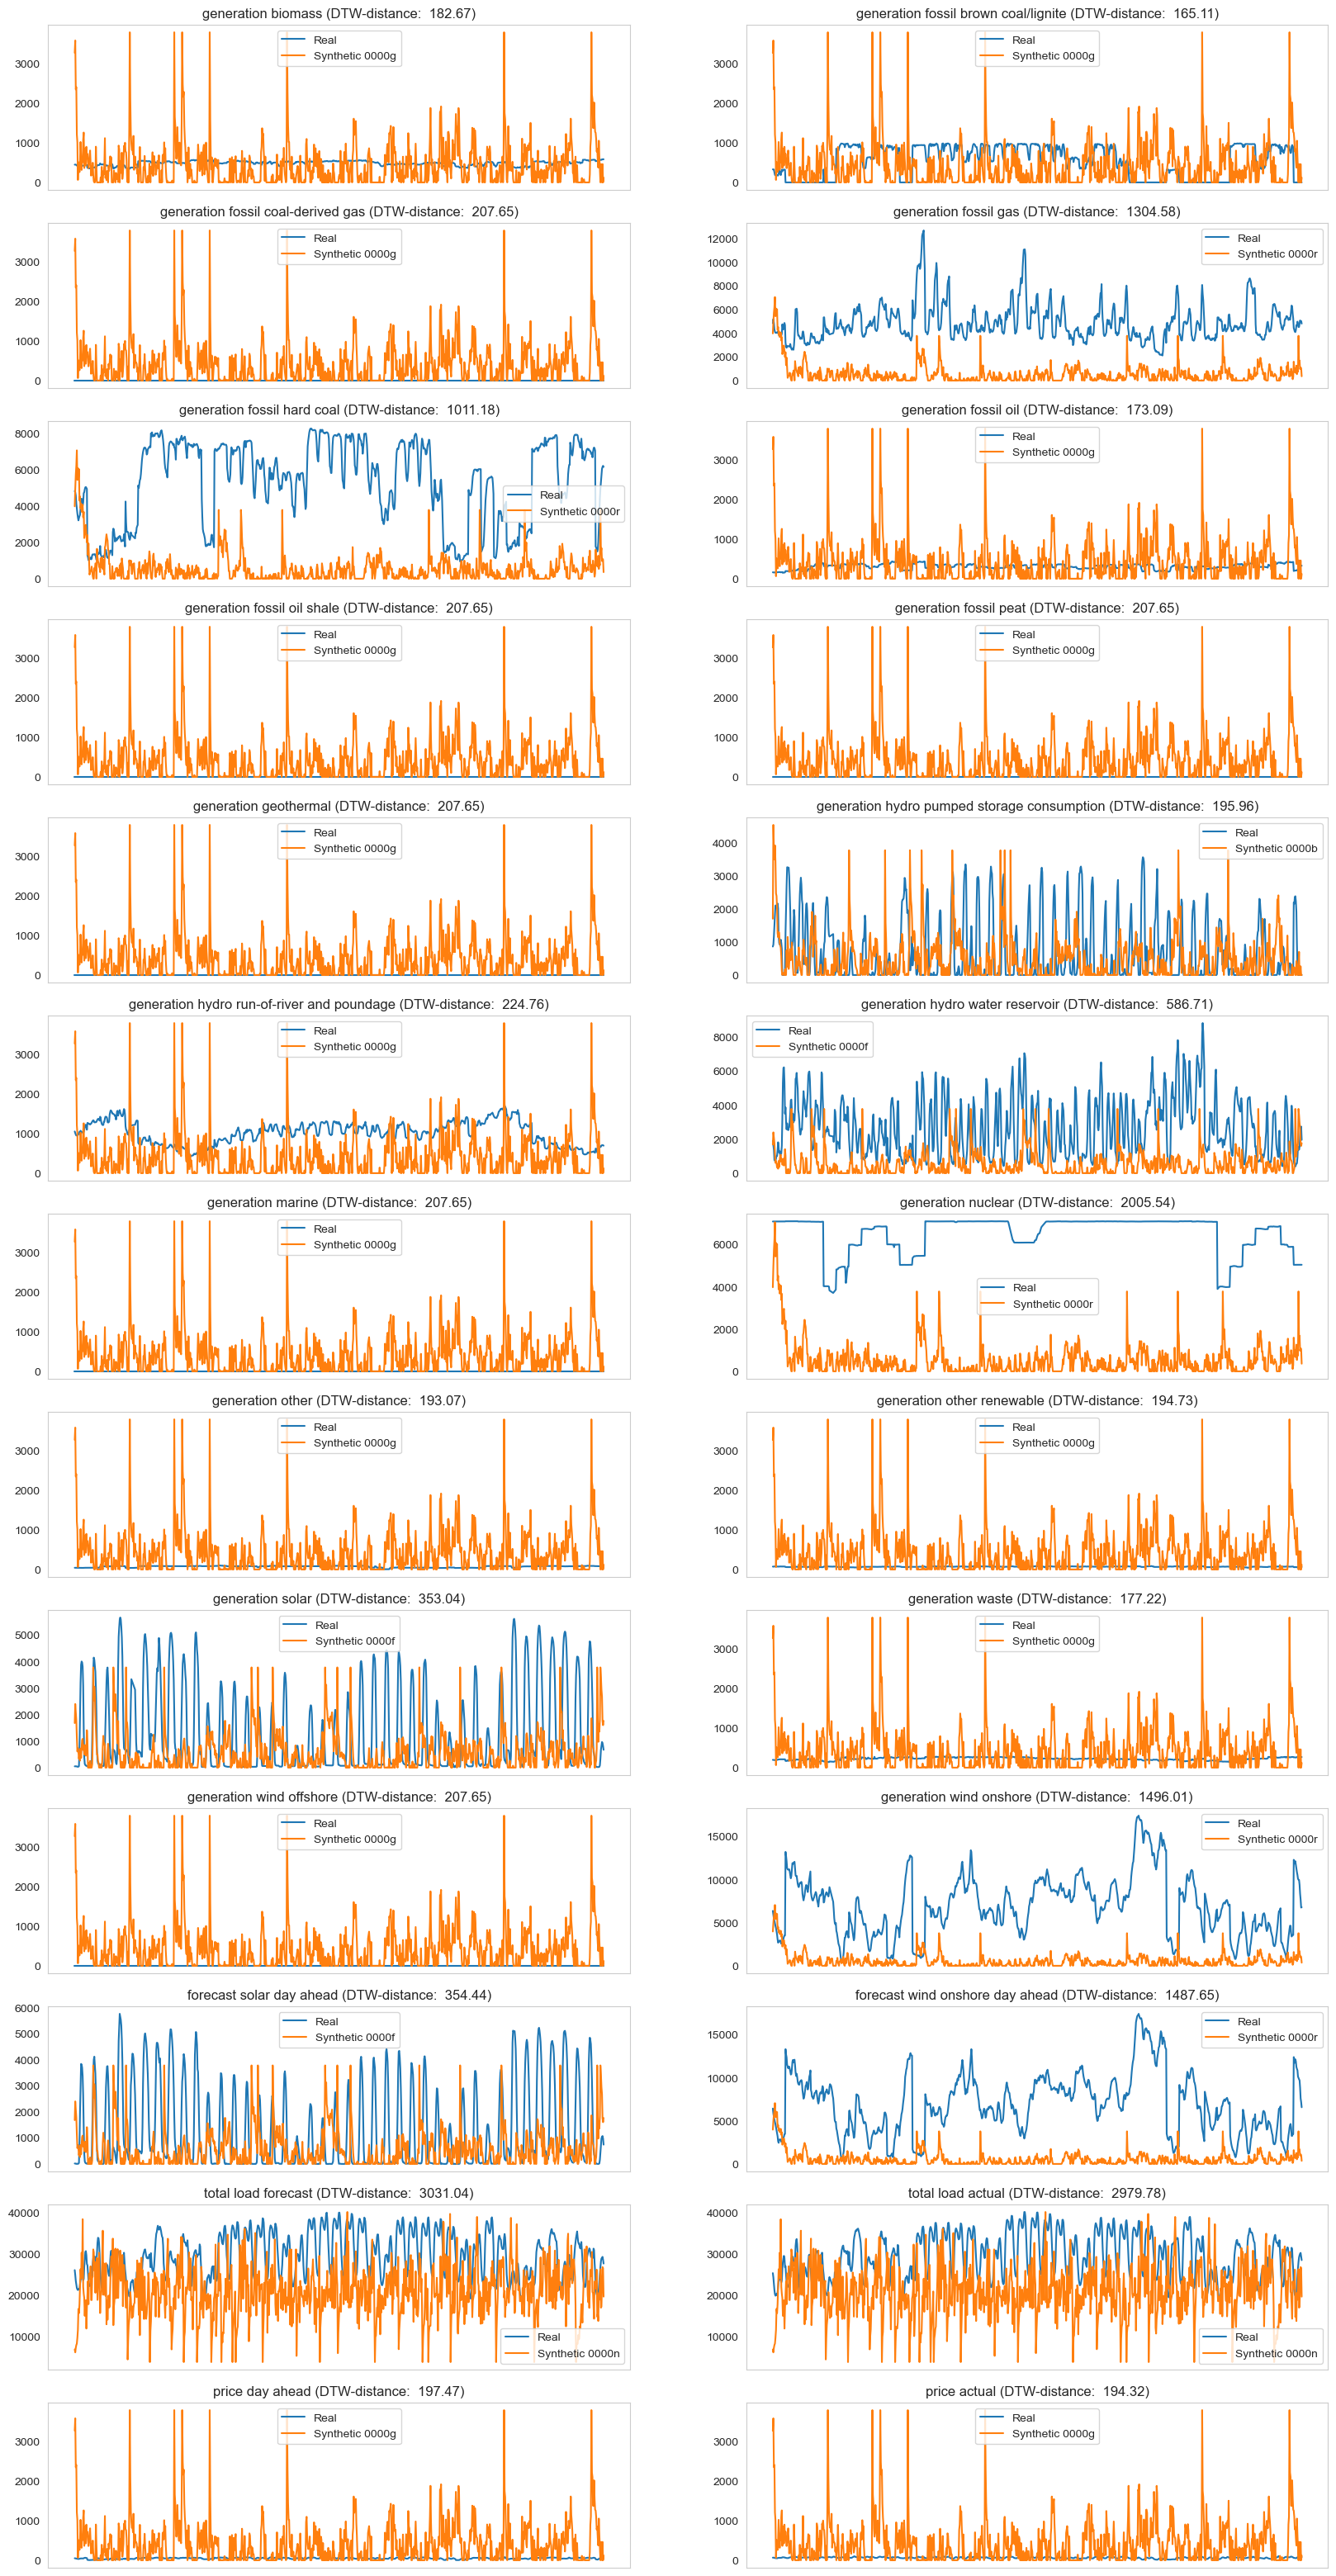

In [20]:
ts_sim.plot_nearest_neighbours(figsize = (20,40), color_real=None, color_synth=None)

## Training on a single TS

In [5]:
def train_single_TS(df_real, metadata, identifier, ts_name, figsize = (20, 5), n_samples = 5, n_epochs = 100, verbose = True, color_real = None, color_synth = None, **fig_kw):
    sns.set_style("whitegrid")

    y_real = df_real[df_real[identifier] == ts_name]

    ts_gen_single = TSGenerator(
        df=y_real,
        metadata=metadata,
        verbose=verbose
    )

    ts_gen_single.train(n_epochs=n_epochs)
    
    df_synth = ts_gen_single.sample(n_samples=n_samples)

    ts_sim_biomass = TSSimilarityCheck(
        df_real=y_real,
        df_synth=df_synth,
        metadata=metadata,
        single = True
    )


    ts_sim_biomass.plot_nearest_neighbours(figsize = figsize, color_real=color_real, color_synth=color_synth, **fig_kw)

    return df_synth

#### Biomass

Pooled DTW: 470\
Single DTW: 14

Epoch 100 | Loss -1521.479248046875: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]
100%|██████████| 5/5 [00:32<00:00,  6.40s/it]


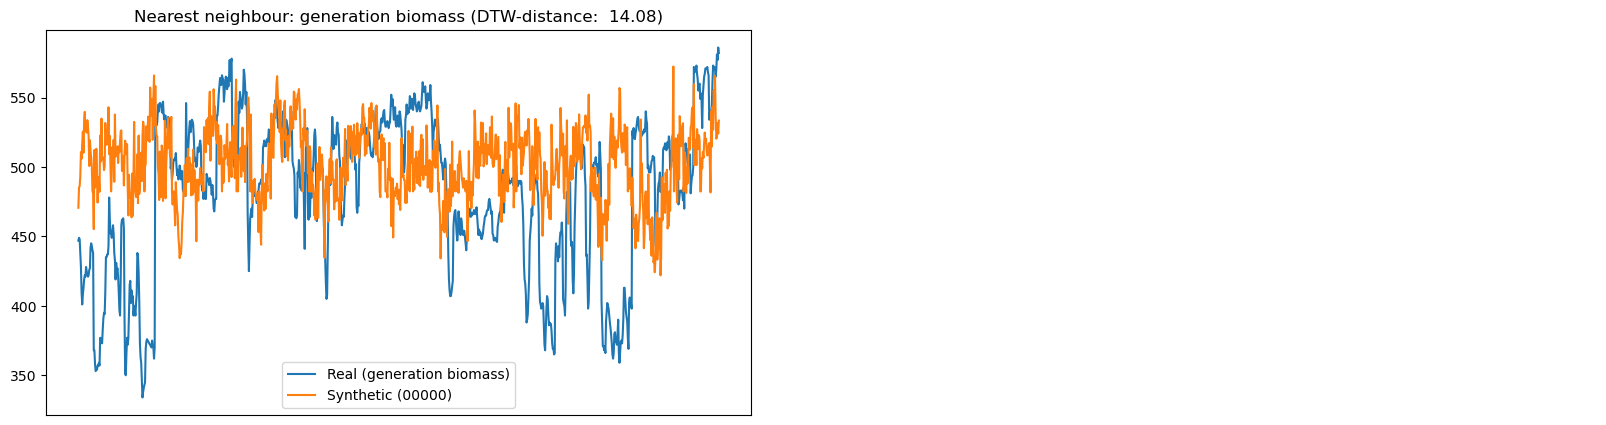

In [18]:
biomass = train_single_TS(df_real, metadata, identifier="variable", ts_name="generation biomass", n_epochs = 100, n_samples = 5, verbose = True)

**Comment:** By training only a model on a single time series we are able to reproduce single time series much better. The DTW-distance is being reduced from 470 to 14!

#### Periodic TS (forecast solar day ahead)

Pooled DTW: 383\
Single DTW: 363

Epoch 1000 | Loss -2247.03173828125: 100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s]
100%|██████████| 5/5 [00:31<00:00,  6.32s/it]


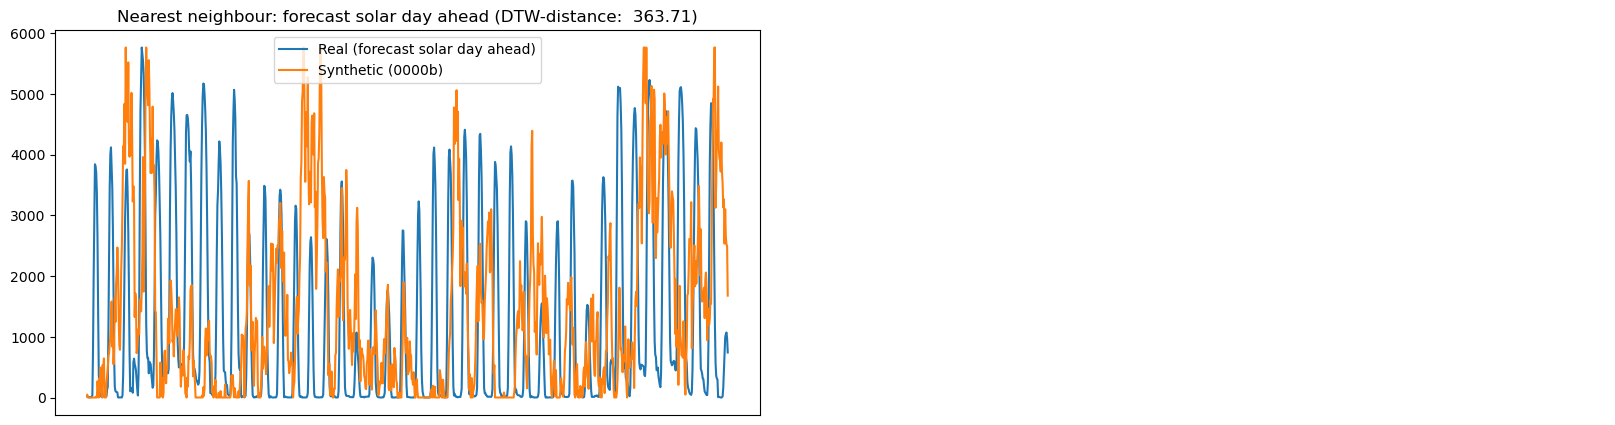

In [20]:
forecast_solar = train_single_TS(df_real, metadata, identifier="variable", ts_name="forecast solar day ahead", n_epochs = 1000, n_samples = 5, verbose = True)

**Comment:** This is worse than training with a lot of different TS!

#### AR-process: Generation wind onshore

Pooled DTW: 1547\
Single DTW: 784

Epoch 1000 | Loss -2427.78515625: 100%|██████████| 1000/1000 [02:51<00:00,  5.83it/s]   
100%|██████████| 5/5 [00:31<00:00,  6.35s/it]


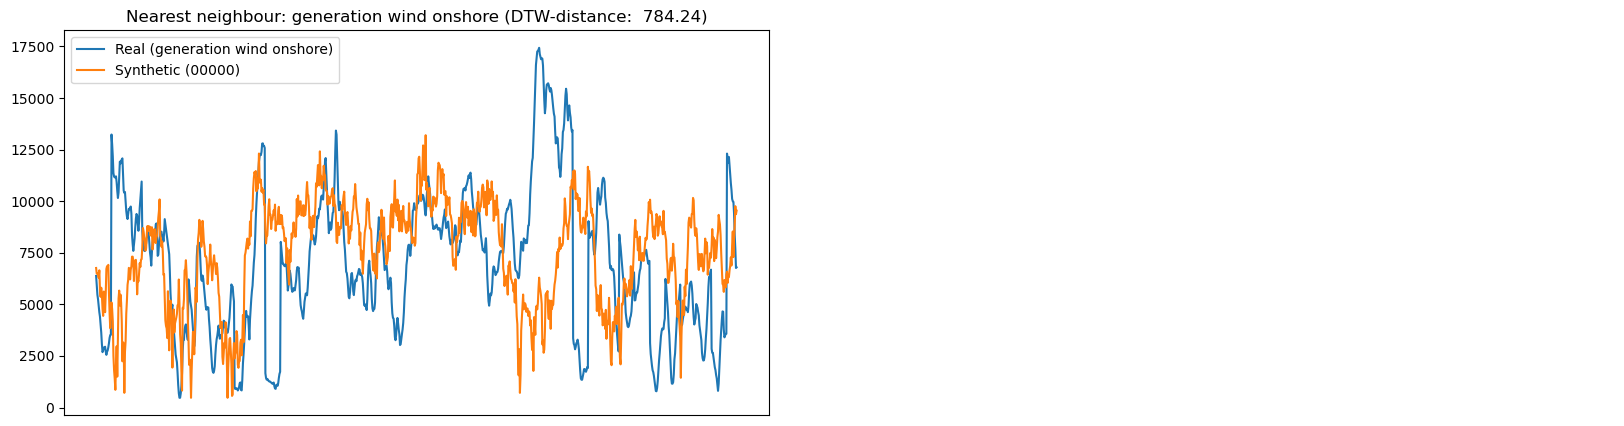

In [21]:
generation_wind = train_single_TS(df_real, metadata, identifier="variable", ts_name="generation wind onshore", n_epochs = 1000, n_samples = 5, verbose = True)

## Evaluation of PAR on single fake TS

Types of TS:
- Exponential Trend
- White Noise
- AR(1)-process
- Constant TS
- Square

In [26]:
# Create dataset with all types of TS in a long format
t_vals = np.arange(1,1001, step = 1)

# Exponential trend: y(t) = e^0.006t + e_t. e_t ~ N(0, 5)
e_t = np.random.normal(0, 5, len(t_vals))
y_exp = np.exp(0.006*t_vals) + e_t
y_exp = y_exp.reshape((-1, 1))

# White noise around a constant: y(t) = 100 + e_t. e_t ~ N(0, 5)
e_t = np.random.normal(100, 5, (len(t_vals), 1))
y_white_noise = e_t.reshape((-1, 1))

# AR(1)-process: y(t) = gamma*y(t-1) + e_t. y_0 = 100, e_t ~ N(0, 5)
e_t = np.random.normal(0, 5, len(t_vals))
y_0 = 0
gamma = 1
y_ar = np.array([y_0])
for i in t_vals[:-1]:
    e_t = np.random.normal(0, 5)
    y_t = gamma*y_ar[i-1] + e_t
    y_ar = np.append(y_ar, y_t)
y_ar = y_ar + 100
y_ar = y_ar.reshape((-1, 1))

# Constant TS: y(t) = 100
y_const = np.array([100]*len(t_vals)).reshape((-1, 1))

# Square wave: y(t) = 100 + I(t%200 < 100)*100
y_square = np.array([200 if (t-1)%200 < 100 else 100 for t in t_vals]).reshape((-1, 1))



# Create dataframe
df_ts = pd.DataFrame(np.concatenate((t_vals.reshape(-1, 1), y_exp, y_white_noise, y_ar, y_const, y_square), axis = 1), columns=["time", "exponential", "white_noise", "random_walk", "constant", "square"])
df_ts

,time,exponential,white_noise,random_walk,constant,square
0,1.0,-3.110962,103.107845,100.000000,100.0,200.0
1,2.0,1.303057,101.080575,101.725973,100.0,200.0
2,3.0,1.285188,99.662848,91.055540,100.0,200.0
3,4.0,-6.797785,97.852181,84.881370,100.0,200.0
4,5.0,4.404467,91.875341,92.461187,100.0,200.0
...,...,...,...,...,...,...
995,996.0,389.826551,94.881926,142.924497,100.0,100.0
996,997.0,401.096280,95.240078,141.545368,100.0,100.0
997,998.0,397.454001,99.435452,146.008427,100.0,100.0
998,999.0,398.275048,101.313068,149.425071,100.0,100.0


In [27]:
data_processor = DataProcessor(df_ts)
# the name of the time column is time in this df and all columns can be used as identifiers in long format
df_ts_long = data_processor.convert_to_long_format(time_columns='time', verbose=False)
metadata_ts = data_processor.get_metadata_long_df(identifier='variable', time_column='time')

### Exponential

Epoch 2000 | Loss -2474.54638671875: 100%|██████████| 2000/2000 [05:29<00:00,  6.07it/s]  
100%|██████████| 10/10 [00:58<00:00,  5.85s/it]


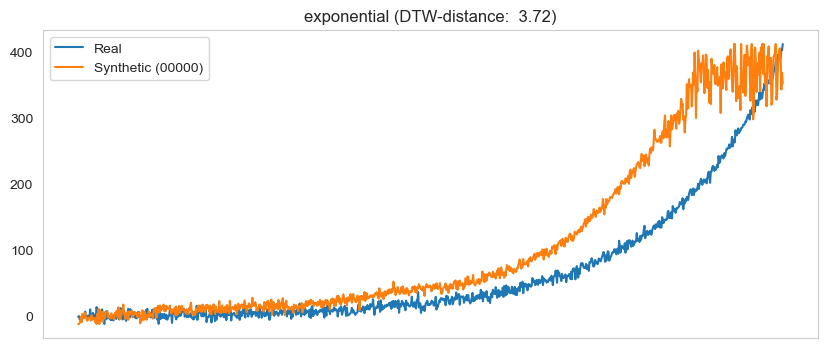

In [36]:
exponential_synth = train_single_TS(df_ts_long, metadata_ts, identifier="variable", ts_name="exponential", n_epochs = 2000, n_samples = 10, verbose = True, figsize=(10,4))

Epoch 3000 | Loss -2446.55859375: 100%|██████████| 3000/3000 [08:16<00:00,  6.05it/s]     
100%|██████████| 10/10 [00:58<00:00,  5.84s/it]


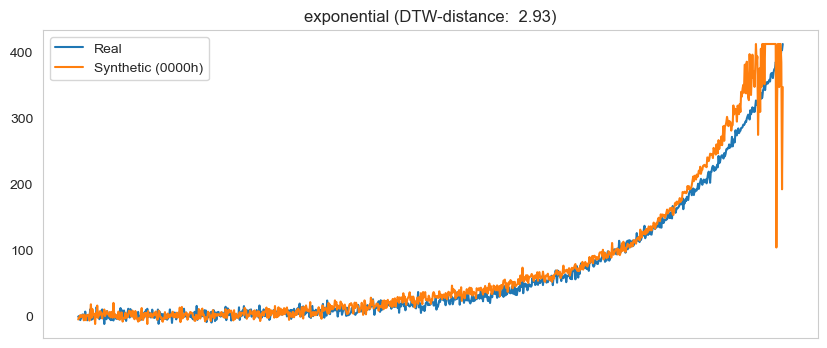

In [37]:
exponential_synth = train_single_TS(df_ts_long, metadata_ts, identifier="variable", ts_name="exponential", n_epochs = 3000, n_samples = 10, verbose = True, figsize=(10,4))

Epoch 2000 | Loss -2809.9599609375: 100%|██████████| 2000/2000 [05:10<00:00,  6.44it/s]   
100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


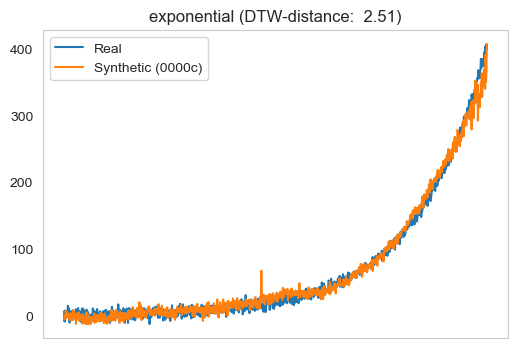

In [9]:
exponential_synth = train_single_TS(df_ts_long, metadata_ts, identifier="variable", ts_name="exponential", n_epochs = 2000, n_samples = 10, verbose = True, figsize=(6,4))

**Comment:** PAR performs quite well, though not perfectly. Especially the end of the series is not exponential anymore.

### White Noise

Epoch 1000 | Loss -1854.4078369140625: 100%|██████████| 1000/1000 [02:53<00:00,  5.76it/s]
100%|██████████| 5/5 [00:33<00:00,  6.76s/it]


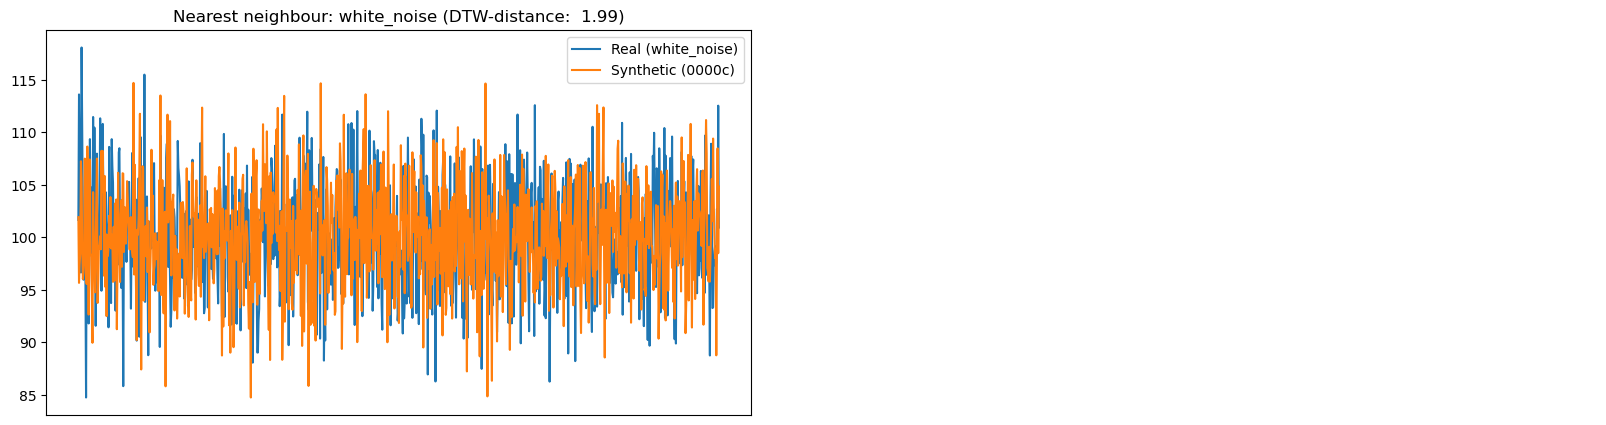

In [29]:
white_noise_synth = train_single_TS(df_ts_long, metadata_ts, identifier="variable", ts_name="white_noise", n_epochs = 1000, n_samples = 5, verbose = True)

**Comment:** PAR is able to model white noise quite well, though one can notice how the model still tries to fit an AR-like model to it, despite the real TS being white noise.

### Random walk

Epoch 300 | Loss -2484.563720703125: 100%|██████████| 300/300 [00:47<00:00,  6.36it/s] 
100%|██████████| 5/5 [00:29<00:00,  5.88s/it]


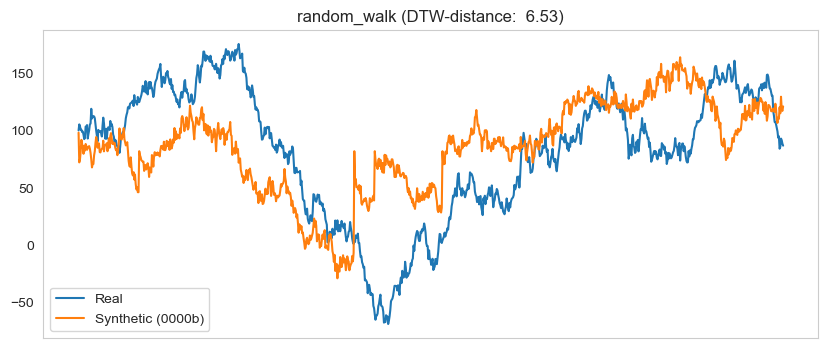

In [25]:
ar_synth = train_single_TS(df_ts_long, metadata_ts, identifier="variable", ts_name="random_walk", n_epochs = 300, n_samples = 5, verbose = True, figsize=(10,4))

Epoch 300 | Loss -2395.854248046875: 100%|██████████| 300/300 [00:49<00:00,  6.07it/s] 
100%|██████████| 5/5 [00:32<00:00,  6.50s/it]


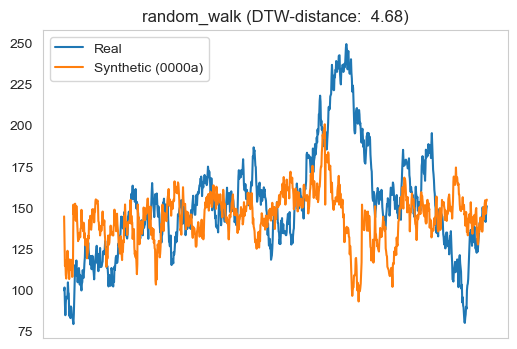

In [28]:
ar_synth = train_single_TS(df_ts_long, metadata_ts, identifier="variable", ts_name="random_walk", n_epochs = 300, n_samples = 5, verbose = True, figsize=(6,4))

**Comment:** As expected the PAR is able to model AR processes very well, the higher the autocorrelation coefficient $\phi$ the better it is.

### Constant

Epoch 100 | Loss -2688.473876953125: 100%|██████████| 100/100 [00:16<00:00,  6.15it/s]
100%|██████████| 5/5 [00:29<00:00,  5.85s/it]


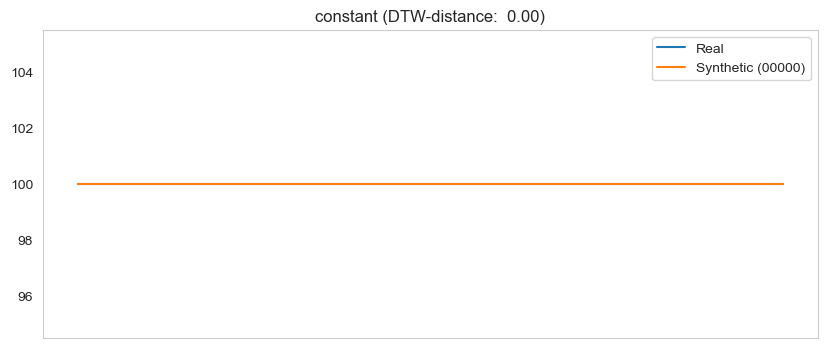

In [29]:
constant = train_single_TS(df_ts_long, metadata_ts, identifier="variable", ts_name="constant", n_epochs = 100, n_samples = 5, verbose = True, figsize=(10,4))

Epoch 100 | Loss -2613.875: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]        
100%|██████████| 5/5 [00:31<00:00,  6.34s/it]


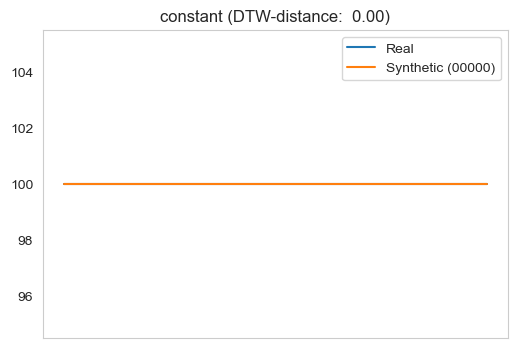

In [17]:
constant = train_single_TS(df_ts_long, metadata_ts, identifier="variable", ts_name="constant", n_epochs = 100, n_samples = 5, verbose = True, figsize=(6,4))

**Comment:** With constant TS, the PAR model is "too perfect". That means that privacy will be compromised !

### Square

Epoch 3000 | Loss -2384.22705078125: 100%|██████████| 3000/3000 [08:21<00:00,  5.98it/s]  
100%|██████████| 5/5 [00:31<00:00,  6.23s/it]


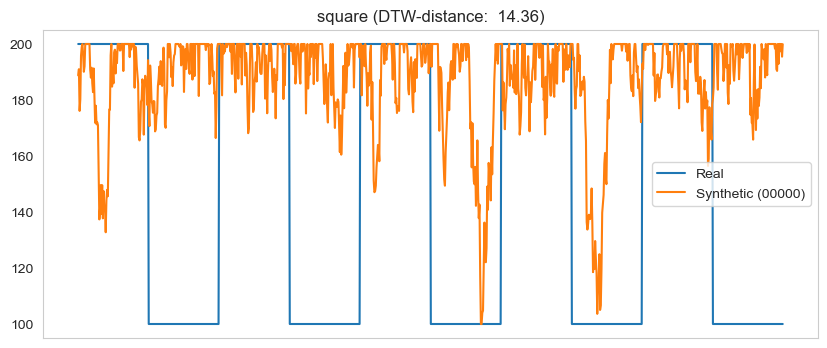

In [14]:
square = train_single_TS(df_ts_long, metadata_ts, identifier="variable", ts_name="square", n_epochs = 3000, n_samples = 5, verbose = True, figsize=(10,4))

Epoch 3000 | Loss -2528.504638671875: 100%|██████████| 3000/3000 [08:38<00:00,  5.79it/s] 
100%|██████████| 5/5 [00:31<00:00,  6.36s/it]


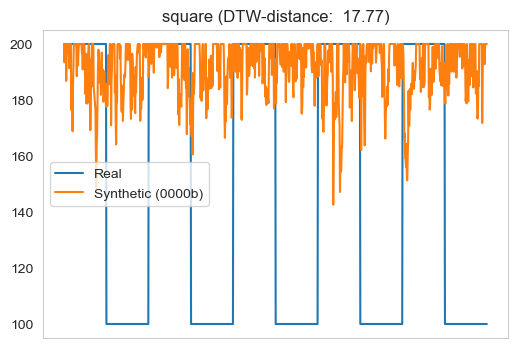

In [13]:
square = train_single_TS(df_ts_long, metadata_ts, identifier="variable", ts_name="square", n_epochs = 3000, n_samples = 5, verbose = True, figsize=(6,4))

**Comment:** This is the weakness of the AR model. The PAR synthesizer is not able to model large changes between y values well. This is probably due to the AR-nature of the model, which doesn't apply to these kind of TS, where you have large drops in between "perfect AR periods".

### Conclusion from fake TS experiments

As soon as the real TS has periods where it does not follow an AR-like process, the model is not able to reproduce similar TS. In the remaining cases, it is pretty good.

## Plots for article

#### a) 3 different real time series

In [8]:
def plot_series(df, title, colors, long = True, figsize = (12,8), **plot_kws):
    if long:
        df = pd.pivot(df, index = "time", columns = "variable", values = "value").reset_index(drop=True)
    # Plot of four time series to show heterogeneity
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize = figsize)
    df.plot(ax = ax, title = title, color = colors, **plot_kws)
    plt.show()

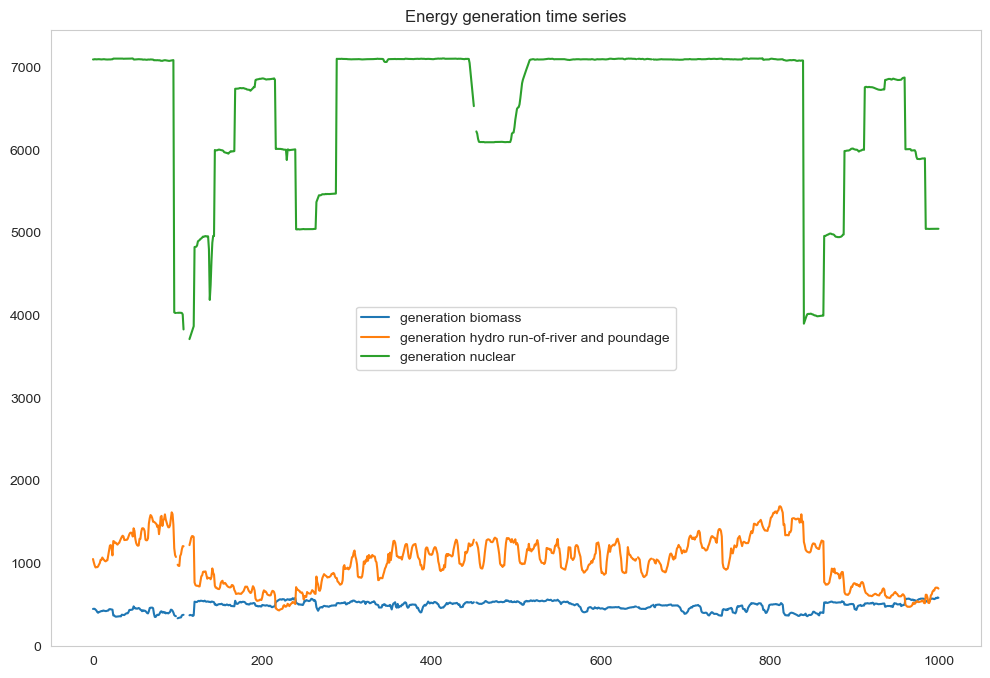

In [54]:
cols_to_show = ["generation biomass", "generation hydro run-of-river and poundage", "generation nuclear"]
df_plot = df[cols_to_show]
df_plot = df_plot.iloc[:1000]
plot_series(df_plot, long = False, title = "Energy generation time series", colors = None, grid = False)

#### b) 10 samples from training on selected time series

In [55]:
ts_gen = TSGenerator(
    df=df_real[df_real["variable"].isin(["title"] + cols_to_show)],
    metadata=metadata,
    verbose=True
)

In [56]:
ts_gen.train(n_epochs=200)

Epoch 200 | Loss -884.8805541992188: 100%|██████████| 200/200 [00:40<00:00,  4.93it/s] 


In [57]:
df_synth = ts_gen.sample(n_samples=10)

100%|██████████| 10/10 [01:01<00:00,  6.12s/it]


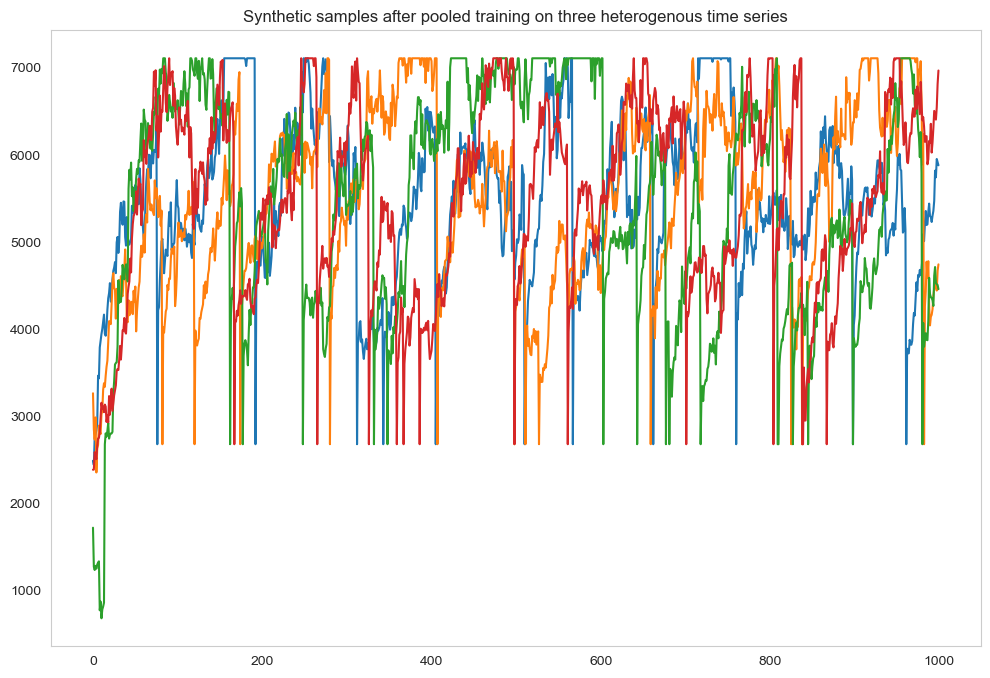

In [58]:
df_plot = pd.pivot(df_synth, index = "time", columns = "variable", values = "value").reset_index(drop=True).iloc[:,:4]
df_plot.plot(legend=False, 
            figsize = (12,8), 
            title = "Synthetic samples after pooled training on three heterogenous time series", 
            xlabel = "",
            color = None,
            grid = False)
plt.show()

#### c) Samples trained individually

In [59]:
df_ind = df_real[df_real["variable"].isin(cols_to_show)]

In [60]:
def train_separate(df_real, cols_to_show, n_epochs, n_samples):
    # Initialize output dataframe
    df_final = pd.DataFrame(columns=df_real.columns)


    for var in tqdm.tqdm(cols_to_show, desc="Sampling"):
        # Subset dataframe to only include series of interest
        df_var = df_real[df_real["variable"] == var]
        
        # Train and sample based on this single series
        ts_gen = TSGenerator(
            df=df_var,
            metadata=metadata,
            verbose=True
        )
        ts_gen.train(n_epochs=n_epochs)
        df_synth = ts_gen.sample(n_samples=n_samples)

        # Compute the dist_matrix to find the best synthetic time series
        ts_sim = TSSimilarityCheck(
            df_real=df_var,
            df_synth=df_synth,
            metadata=metadata
        )

        # Compute distance matrix and Find the nearest neighbour's name
        dist_matrix = ts_sim.compute_distance_matrix()
        nn_name = dist_matrix.idxmin(axis=0)

        # Take nearest neighbour and append to final dataframe
        df_nn = df_synth[df_synth["variable"] == nn_name.values[0]]
        df_nn = df_nn.assign(variable = var)
        df_final = pd.concat([df_final, df_nn], axis = 0)

    return df_final

In [61]:
df_indiv = train_separate(df_real, cols_to_show, 500, 5)

Epoch 500 | Loss -1531.5382080078125: 100%|██████████| 500/500 [01:18<00:00,  6.38it/s]
100%|██████████| 5/5 [00:30<00:00,  6.13s/it]
Epoch 500 | Loss -2464.360107421875: 100%|██████████| 500/500 [01:24<00:00,  5.93it/s]
100%|██████████| 5/5 [00:32<00:00,  6.41s/it]
Epoch 500 | Loss -2317.928466796875: 100%|██████████| 500/500 [01:18<00:00,  6.40it/s]
Sampling: 100%|██████████| 3/3 [05:35<00:00, 111.77s/it]


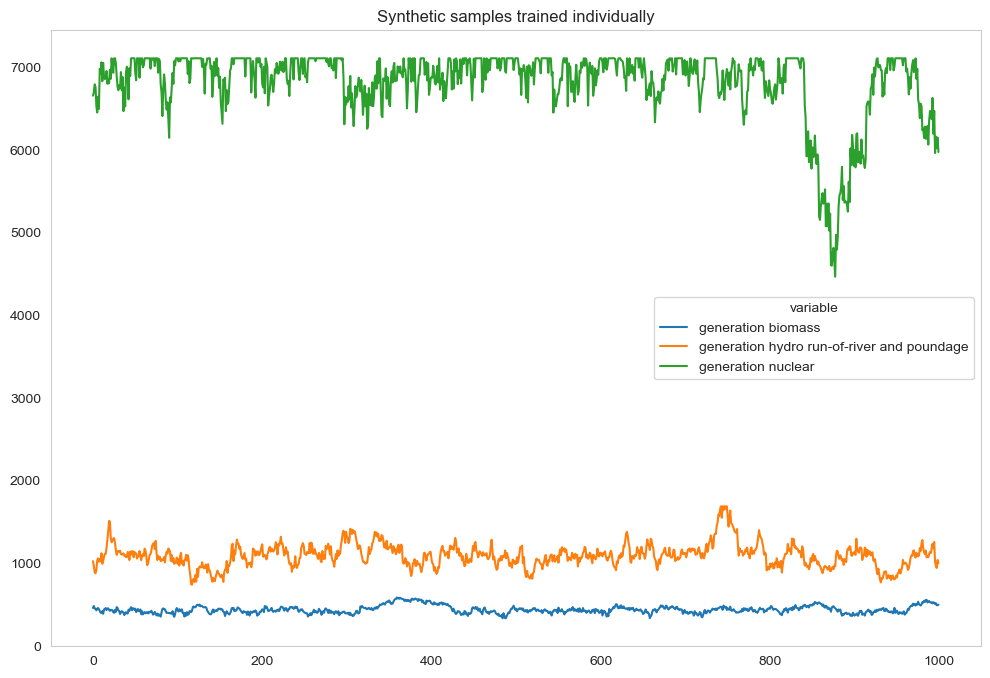

In [62]:
plot_series(df_indiv, "Synthetic samples trained individually", colors=None, long = True, grid = False)

#### d) Individual nice sequences of the energy dataset

Epoch 100 | Loss -1515.8411865234375: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]
100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


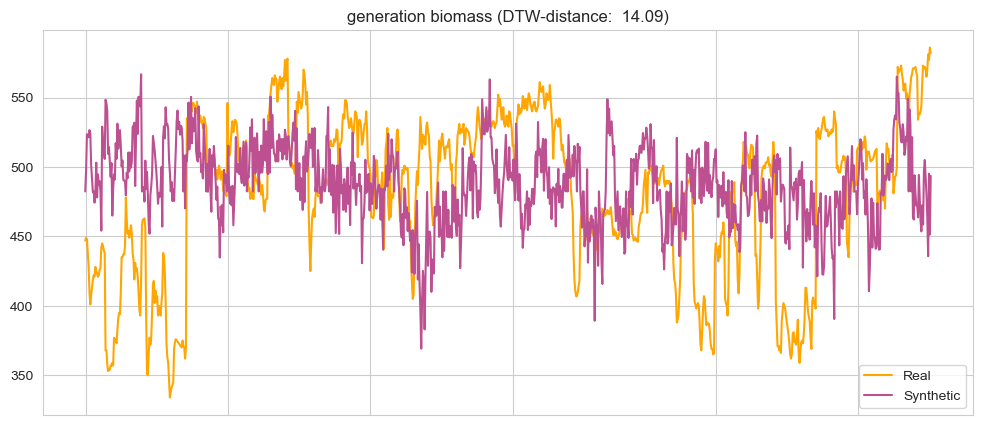

In [13]:
biomass = train_single_TS(df_real, metadata, identifier="variable",
                                ts_name="generation biomass", 
                                n_epochs = 100, n_samples = 1, 
                                verbose = True, 
                                color_real=color_plots[3],
                                color_synth=color_plots[1],
                                figsize=(12,5))

Epoch 200 | Loss -1454.325927734375: 100%|██████████| 200/200 [00:31<00:00,  6.34it/s] 
100%|██████████| 5/5 [00:31<00:00,  6.31s/it]


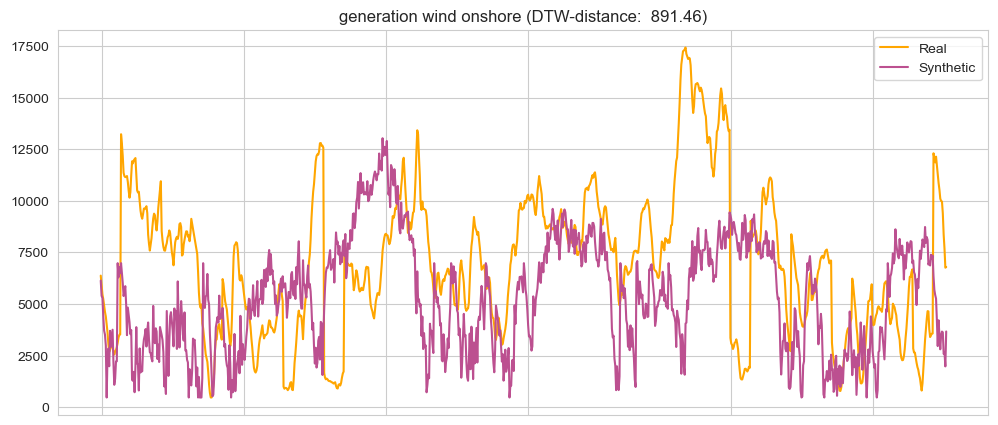

In [16]:
wind = train_single_TS(df_real, metadata, identifier="variable",
                                ts_name="generation wind onshore", 
                                n_epochs = 200, n_samples = 5, 
                                verbose = True, 
                                color_real=color_plots[3],
                                color_synth=color_plots[1],
                                figsize=(12,5))

Epoch 1 | Loss 1360.625: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]
100%|██████████| 1/1 [00:06<00:00,  6.35s/it]


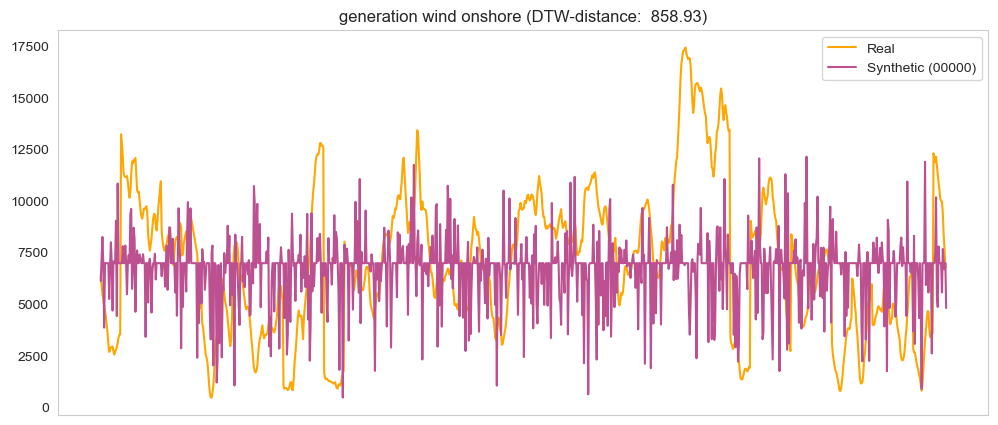

In [7]:
wind = train_single_TS(df_real, metadata, identifier="variable",
                                ts_name="generation wind onshore", 
                                n_epochs = 1, n_samples = 1, 
                                verbose = True, 
                                color_real=color_plots[3],
                                color_synth=color_plots[1],
                                figsize=(12,5))